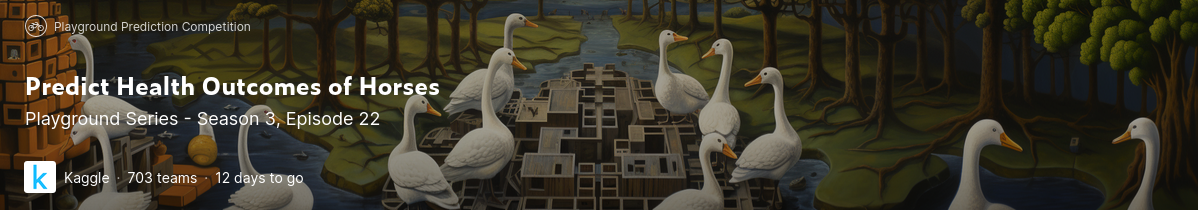

# Import Libraries

In [102]:
# Data
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder 
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer

# Models
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from sklearn.metrics import f1_score

In [103]:
root_folder = "../data/"
# root_folder = "/kaggle/input/playground-series-s3e22/"

In [104]:
train = pd.read_csv(root_folder + 'train.csv')
test = pd.read_csv(root_folder + 'test.csv')
sample_submission = pd.read_csv(root_folder + 'sample_submission.csv')

In [105]:
train

,id,surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,...,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data,outcome
0,0,yes,adult,530001,38.1,132.0,24.0,cool,reduced,dark_cyanotic,...,57.0,8.5,serosanguious,3.4,yes,2209,0,0,no,died
1,1,yes,adult,533836,37.5,88.0,12.0,cool,normal,pale_cyanotic,...,33.0,64.0,serosanguious,2.0,yes,2208,0,0,no,euthanized
2,2,yes,adult,529812,38.3,120.0,28.0,cool,reduced,pale_pink,...,37.0,6.4,serosanguious,3.4,yes,5124,0,0,no,lived
3,3,yes,adult,5262541,37.1,72.0,30.0,cold,reduced,pale_pink,...,53.0,7.0,cloudy,3.9,yes,2208,0,0,yes,lived
4,4,no,adult,5299629,38.0,52.0,48.0,normal,normal,normal_pink,...,47.0,7.3,cloudy,2.6,no,0,0,0,yes,lived
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1230,1230,yes,adult,535246,38.5,129.0,48.0,cool,reduced,pale_pink,...,57.0,66.0,serosanguious,2.0,yes,2206,0,0,no,lived
1231,1231,yes,adult,528570,37.5,60.0,50.0,cool,reduced,pale_cyanotic,...,35.0,6.4,serosanguious,3.6,yes,2209,0,0,yes,died
1232,1232,yes,young,529685,37.5,84.0,40.0,normal,reduced,normal_pink,...,40.0,5.9,cloudy,7.0,yes,400,0,0,yes,lived
1233,1233,yes,adult,534784,38.1,70.0,16.0,normal,reduced,bright_red,...,58.0,74.0,cloudy,2.0,yes,2209,0,0,no,lived


# EDA

In [106]:
train.dtypes

id                         int64
surgery                   object
age                       object
hospital_number            int64
rectal_temp              float64
pulse                    float64
respiratory_rate         float64
temp_of_extremities       object
peripheral_pulse          object
mucous_membrane           object
capillary_refill_time     object
pain                      object
peristalsis               object
abdominal_distention      object
nasogastric_tube          object
nasogastric_reflux        object
nasogastric_reflux_ph    float64
rectal_exam_feces         object
abdomen                   object
packed_cell_volume       float64
total_protein            float64
abdomo_appearance         object
abdomo_protein           float64
surgical_lesion           object
lesion_1                   int64
lesion_2                   int64
lesion_3                   int64
cp_data                   object
outcome                   object
dtype: object

In [107]:
train.drop(columns=['id', 'cp_data'], inplace=True)
test.drop(columns=['id', 'cp_data'], inplace=True)
train_columns = train.columns
test_columns = test.columns

In [108]:
train.shape

(1235, 27)

In [109]:
train.drop_duplicates(inplace=True)
test.drop_duplicates(inplace=True)

In [110]:
train.isnull().sum()

surgery                    0
age                        0
hospital_number            0
rectal_temp                0
pulse                      0
respiratory_rate           0
temp_of_extremities       39
peripheral_pulse          60
mucous_membrane           21
capillary_refill_time      6
pain                      44
peristalsis               20
abdominal_distention      23
nasogastric_tube          80
nasogastric_reflux        21
nasogastric_reflux_ph      0
rectal_exam_feces        190
abdomen                  213
packed_cell_volume         0
total_protein              0
abdomo_appearance         48
abdomo_protein             0
surgical_lesion            0
lesion_1                   0
lesion_2                   0
lesion_3                   0
outcome                    0
dtype: int64

In [111]:
test.isnull().sum()

surgery                    0
age                        0
hospital_number            0
rectal_temp                0
pulse                      0
respiratory_rate           0
temp_of_extremities       35
peripheral_pulse          47
mucous_membrane           13
capillary_refill_time      6
pain                      29
peristalsis               19
abdominal_distention      22
nasogastric_tube          64
nasogastric_reflux        14
nasogastric_reflux_ph      0
rectal_exam_feces        125
abdomen                  154
packed_cell_volume         0
total_protein              0
abdomo_appearance         31
abdomo_protein             0
surgical_lesion            0
lesion_1                   0
lesion_2                   0
lesion_3                   0
dtype: int64

In [112]:
cat_features_train = train.select_dtypes(include=['object']).columns.tolist()
num_features_train = [i for i in train.columns if i not in cat_features_train]
cat_features_test = test.select_dtypes(include=['object']).columns.tolist()
num_features_test = [i for i in test.columns if i not in cat_features_test]

In [113]:
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy='most_frequent')),
    ("onehot", OneHotEncoder(drop="first", handle_unknown="ignore"))
])

In [114]:
numerical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer()),
    ("scaler", StandardScaler())
])

In [115]:
preprocessor_train = ColumnTransformer(transformers=[
    ("numerical", numerical_transformer, num_features_train),
    ("categorical", categorical_transformer, cat_features_train)])

preprocessor_test = ColumnTransformer(transformers=[
    ("numerical", numerical_transformer, num_features_test),
    ("categorical", categorical_transformer, cat_features_test)])

preprocessor_train

ColumnTransformer(transformers=[('numerical',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('scaler', StandardScaler())]),
                                 ['hospital_number', 'rectal_temp', 'pulse',
                                  'respiratory_rate', 'nasogastric_reflux_ph',
                                  'packed_cell_volume', 'total_protein',
                                  'abdomo_protein', 'lesion_1', 'lesion_2',
                                  'lesion_3']),
                                ('categorical',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent'))]),
                                 ['surgery', 'age', 'temp_of_extremities',
                                  'peripheral_pulse', 'mucous_membrane',
                                  'capillary_refill_time', 'pain',
                                  'peristalsis', 'abdominal_distention',
                                  'nasogastric_tube', 'nasogastric_reflux',
                                  'rectal_exam_feces', 'abdomen',
                                  'abdomo_appearance', 'surgical_lesion',
                                  'outcome'])])

In [116]:
train = preprocessor_train.fit_transform(train)
test = preprocessor_test.fit_transform(test)

In [117]:
train.shape

(1235, 27)

In [122]:
train = pd.DataFrame(train, columns=train_columns)
test = pd.DataFrame(test, columns=test_columns)

In [123]:
test.isnull().sum()

surgery                  0
age                      0
hospital_number          0
rectal_temp              0
pulse                    0
respiratory_rate         0
temp_of_extremities      0
peripheral_pulse         0
mucous_membrane          0
capillary_refill_time    0
pain                     0
peristalsis              0
abdominal_distention     0
nasogastric_tube         0
nasogastric_reflux       0
nasogastric_reflux_ph    0
rectal_exam_feces        0
abdomen                  0
packed_cell_volume       0
total_protein            0
abdomo_appearance        0
abdomo_protein           0
surgical_lesion          0
lesion_1                 0
lesion_2                 0
lesion_3                 0
dtype: int64

In [124]:
train.to_csv(root_folder + 'train.csv')
test.to_csv(root_folder + 'test.csv')